<a href="https://colab.research.google.com/github/martinpius/Behind-Keras-Layers-and-Models/blob/main/Kera's_Layers_and_Models_Subclassing_end_to_end_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount = True)
try:
  COLAB = True
  import tensorflow as tf
  print(f"You are running on Colab with tensorflow version: {tf.__version__}")
except Exception as e:
  COLAB = False
  print(f"{type(e)}{e}\n...Please Load Your Drive...")

def time_setter(t):
  h = int(t / (60 * 60))
  m = int(t % (60 * 60)/ 60)
  s = int(t % 60)
  return f"{h}: {m:>02}: {s:>05.2f}"
time_setter(123.8972)

Mounted at /content/drive/
You are running on Colab with tensorflow version: 2.4.0


'0: 02: 03.00'

In [13]:
import tensorflow as tf
from tensorflow import keras
import numpy as np


In [3]:
#Layer's subclassing with add_loss and add_metrics methods for a binary logistic

In [4]:
class BinLog(keras.layers.Layer):
  def __init__(self, name = None):
    super(BinLog, self).__init__(name = name)
    self.los_fn = keras.losses.BinaryCrossentropy(from_logits=True)
    self.metric_fn = keras.metrics.BinaryAccuracy()
  
  def call(self, y_real, y_hat, sample_weights = None):
    my_loss = self.los_fn(y_real, y_hat, sample_weights)
    self.add_loss(my_loss)
    my_acc = self.metric_fn(y_real, y_hat, sample_weights)
    self.add_metric(my_acc, name ='accuracy_bin')
    return tf.nn.softmax(y_hat)



In [5]:
#Tracking the above metrics using fit()

In [6]:
inputs = keras.Input(shape = (15,), name = 'inputs')
y_real = keras.Input(shape = (10,), name = 'labels')
y_hat = keras.layers.Dense(units = 10, activation =  'softmax')(inputs)
preds = BinLog(name = 'my_predictions')(y_hat, y_real)
model = keras.Model(inputs = [inputs, y_real], outputs = preds)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 15)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           160         inputs[0][0]                     
__________________________________________________________________________________________________
labels (InputLayer)             [(None, 10)]         0                                            
__________________________________________________________________________________________________
my_predictions (BinLog)         (None, 10)           2           dense[0][0]                      
                                                                 labels[0][0]                 

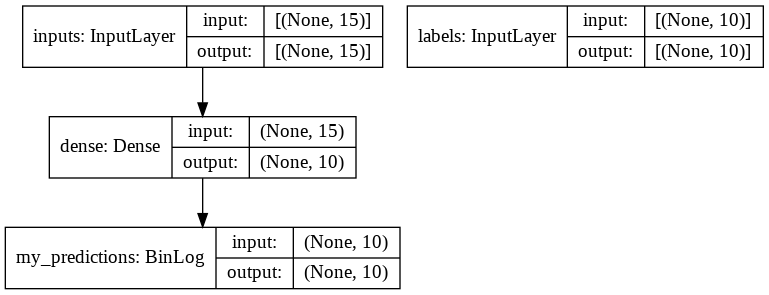

In [7]:
model.summary()
keras.utils.plot_model(model = model, to_file = 'binlog.png', show_shapes = True)

In [8]:
model.compile(optimizer = 'Adam') #We may train the model without the main loss but main loss inclussion may improve the performance

In [9]:
dfm = {'inputs':np.random.random(size = (10,15)),
       'labels': np.random.random(size = (10,10))}

In [10]:
model.fit(dfm, epochs = 3)

Epoch 1/3
1/1 [==============================] - 1s 521ms/step - loss: 0.9404 - binary_accuracy: 0.0000e+00
Epoch 2/3
1/1 [==============================] - 0s 5ms/step - loss: 0.9404 - binary_accuracy: 0.0000e+00
Epoch 3/3
1/1 [==============================] - 0s 4ms/step - loss: 0.9403 - binary_accuracy: 0.0000e+00


In [11]:

#End-to End autoencoder's using layer's and model's subclassing

In [14]:
#VAE consists of 3 main parts
#The encoder: This encoding the data into some representation
#The decoder: This decode the data back to its original representation (reconstruction)
#Autoencoder: Combining the two above from end to end

In [121]:
class SampleGen(keras.layers.Layer):
  def call(self,inputs):
    '''We sample from a normal distribution to obtain reinputs for the reconstruction of original inputs'''
    mu, sigma = inputs
    dim1 = tf.shape(mu)[0]
    dim2 = tf.shape(mu)[1]
    eps = tf.keras.backend.random_normal(shape = (dim1, dim2))
    return mu + tf.exp(0.5 * sigma) * eps


In [122]:
#We apply layer subclassing to build an encoder's which take the original inputs to some representation:
class Encoder(keras.layers.Layer):
  def __init__(self, hidden = 128, intermediate = 64, name = 'encoder', **kwargs):
    super(Encoder, self).__init__(name = name, **kwargs)
    self.dense1 = keras.layers.Dense(units = intermediate, kernel_initializer = 'random_normal', activation = 'relu')
    self.dense_mu = keras.layers.Dense(units = hidden, kernel_initializer = 'random_normal', activation = 'relu')
    self.sigma_dense = keras.layers.Dense(units = hidden, kernel_initializer = 'random_normal', activation = 'relu')
    self.sample_generator = SampleGen()

  def call(self, inputs):
    x = self.dense1(inputs)
    mu = self.dense_mu(x)
    sigma = self.sigma_dense(x)
    z = self.sample_generator((mu, sigma))
    return mu, sigma, z 


In [123]:
#We again use layer's subclassing to reconstruct our original data using the normal distributed samples.(Decoder):
class Decoder(keras.layers.Layer):
  def __init__(self, original_dim, hidden = 128, name = 'decoder', **kwargs):
    super(Decoder, self).__init__(name = name, **kwargs)
    self.dense1 = tf.keras.layers.Dense(units = hidden, kernel_initializer = 'random_normal', activation = 'relu')
    self.out = tf.keras.layers.Dense(units = original_dim, activation = 'sigmoid')
  
  def call(self, inputs):
    x = self.dense1(inputs)
    return self.out(x)



In [124]:
#Using model-subclassing, we write the autoencoder which combines both of the three classes above:
class AutoEncoder(keras.Model):
  def __init__(self, original_dim, hidden = 128, intermediate = 64, name = 'autoencoder', **kwargs):
    super(AutoEncoder, self).__init__(name = name, **kwargs)
    self.original_dim = original_dim
    self.encoder = Encoder(hidden = hidden, intermediate = intermediate)
    self.decoder = Decoder(original_dim = original_dim, hidden = hidden)

  def call(self, inputs):
    mu, sigma, z = self.encoder(inputs)
    dt_rec = self.decoder(z)
    kl_loss= -0.5 * tf.reduce_mean(sigma - tf.square(mu) - tf.exp(sigma) + 1)
    self.add_loss(kl_loss)
    return dt_rec

In [125]:
#Training phrase: We will use the mnist data (reshape into a 2 dimensional shape and use the images as normal data)

In [126]:
#Instantiating our model class
original_dim = 784 
VAE = AutoEncoder(original_dim, 128, 64)

In [127]:
#Load the mnist train set

In [128]:
(x_train,_),(_, _) = tf.keras.datasets.mnist.load_data()

In [129]:
x_train = x_train.reshape(60000,784).astype('float32')/255

In [130]:
#Convert to tensoflow data and splits into batches of size 64 each

In [131]:
train_data = tf.data.Dataset.from_tensor_slices(x_train)
train_data = train_data.shuffle(buffer_size = 1024).batch(64)

In [132]:
optimizer = keras.optimizers.Adam(learning_rate= 1e-3)
loss_fn = keras.losses.MeanSquaredError()
metric_fn = keras.metrics.Mean()


In [133]:
epochs = 20

In [134]:
#Iterate over the epochs:
for epoch in range(epochs):
  print(f"The beginining of epoch: {epoch}")

  #iterate over the training batches:
  for step, x_batch_train, in enumerate(train_data):
    with tf.GradientTape() as tape:
      rec_data = VAE(x_batch_train)
      main_loss = loss_fn(rec_data, x_batch_train)
      main_loss+=sum(VAE.losses) #Adding KL loss to the main loss(MSE)
    grads = tape.gradient(main_loss, VAE.trainable_weights)
    optimizer.apply_gradients(zip(grads, VAE.trainable_weights))

    metric_fn(main_loss)
    if step % 100 == 0:
      print("step %d: mean loss = %.4f" % (step, metric_fn.result()))

The beginining of epoch: 0
step 0: mean loss = 0.2423
step 100: mean loss = 0.1072
step 200: mean loss = 0.0889
step 300: mean loss = 0.0821
step 400: mean loss = 0.0788
step 500: mean loss = 0.0766
step 600: mean loss = 0.0751
step 700: mean loss = 0.0740
step 800: mean loss = 0.0732
step 900: mean loss = 0.0725
The beginining of epoch: 1
step 0: mean loss = 0.0723
step 100: mean loss = 0.0719
step 200: mean loss = 0.0716
step 300: mean loss = 0.0712
step 400: mean loss = 0.0710
step 500: mean loss = 0.0708
step 600: mean loss = 0.0706
step 700: mean loss = 0.0704
step 800: mean loss = 0.0702
step 900: mean loss = 0.0700
The beginining of epoch: 2
step 0: mean loss = 0.0699
step 100: mean loss = 0.0698
step 200: mean loss = 0.0698
step 300: mean loss = 0.0697
step 400: mean loss = 0.0696
step 500: mean loss = 0.0695
step 600: mean loss = 0.0694
step 700: mean loss = 0.0693
step 800: mean loss = 0.0693
step 900: mean loss = 0.0692
The beginining of epoch: 3
step 0: mean loss = 0.0691
s